# HOMEWORK 1 DEEP LEARNING

## Question 1

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy as sp
import time


!pip install wandb
import wandb


train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=
transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
transforms.Compose([transforms.ToTensor()]))

labels_name = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker ', 'bag', 'ankle_boots']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.7 MB/s eta 0:00:00


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
print(f"The size of train set data is = \t {train_set.data.shape} \n")
print(f"The size of train set labels is = \t {train_set.targets.shape} \n")
print(f"The size of train set data is = \t {test_set.data.shape}\n")
print(f"The size of test set labels is = \t {test_set.targets.shape} \n" )

The size of train set data is = 	 torch.Size([60000, 28, 28]) 

The size of train set labels is = 	 torch.Size([60000]) 

The size of train set data is = 	 torch.Size([10000, 28, 28])

The size of test set labels is = 	 torch.Size([10000]) 



In [3]:
print(f"Unique classes: {np.unique(train_set.targets, return_counts = True)}")

Unique classes: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


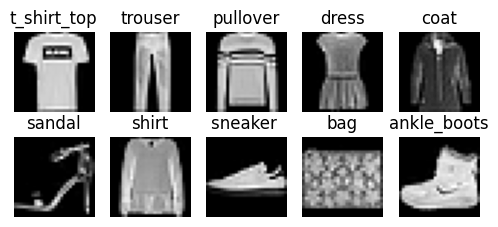

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(6, 2.5))
[axi.set_axis_off() for axi in axes.ravel()]
for i, ax in enumerate(axes.flat):
    img_index = next(idx for idx, label in enumerate(train_set.targets) if label == i)
    ax.imshow(train_set.data[img_index], cmap='gray')
    ax.set_title(labels_name[train_set.targets[img_index]])
plt.show()

In [5]:
# activation functions
# sigmoid
def sigmoid(z):
    return 1.0 / (1 + np.exp(-(z)))

# derivative of sigmoid
def diff_sigmoid(z):
    return (1.0 / (1 + np.exp(-(z)))) * (1 - 1.0 / (1 + np.exp(-(z))))

# tanh
def tanh(z):
    return np.tanh(z)

# derivative of tanh
def diff_tanh(z):
    return 1 - np.tanh(z) ** 2

#relu
def relu(z):
    #np.maximum(z, 0)
    return  (z>0)*(z) + ((z<0)*(z)*0.01)

# derivative of relu
def diff_relu(z):
    #np.where(z >= 0, 1, 0)
    return  (z>0)*np.ones(z.shape) + (z<0)*(0.01*np.ones(z.shape) )

# softmax
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtracting the maximum value to avoid overflow
    return exp_z / np.sum(exp_z, axis=0, keepdims=True, out=None)

In [6]:
# feed forward neural network

class FeedforwardNN:
    def __init__(self, nh_layers, nh_neurons, un_train_data, un_train_targets, n_train, un_val_data, un_val_targets, n_val, un_test_data, un_test_targets, n_test, optimizer, batch_size, weight_decay, lr, max_epochs, activation_fun, initializer):
        self.nh_layers = nh_layers
        self.nh_neurons = nh_neurons
        self.input_size = 28*28
        self.output_size = 10
        self.n_classes = 10
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = n_test
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.lr = lr

        # define the all the layers in the feed forward neural net
        self.nn_layers = ([self.input_size] + self.nh_layers * [self.nh_neurons] + [self.output_size])

        # reshape the data to get shape of (28*28, N)
        self.train_data = np.transpose(un_train_data.reshape(un_train_data.shape[0], un_train_data.shape[1] * un_train_data.shape[2]))
        self.val_data = np.transpose(un_val_data.reshape(un_val_data.shape[0], un_val_data.shape[1] * un_val_data.shape[2]))
        self.test_data = np.transpose(un_test_data.reshape(un_test_data.shape[0], un_test_data.shape[1], un_test_data.shape[2]))

        # one hot encoding of the targets
        self.train_targets = self.one_hot_encode(un_train_targets)
        self.val_targets = self.one_hot_encode(un_val_targets)
        self.test_targets = self.one_hot_encode(un_test_targets)

        # normalizing  the pixel values to be between (0 and 1) for better processing
        self.train_data = self.train_data / 255
        self.val_data = self.val_data / 255
        self.test_data = self.test_data / 255


        # define dictionary for activation functions
        self.dictionary_activation = {"relu": relu, "tanh": tanh, "sigmoid": sigmoid}
        self.activation = self.dictionary_activation[activation_fun]

        # define dictionary for differentiation of activation functions
        self.dictionary_diff_activation = {"relu": diff_relu, "tanh": diff_tanh, "sigmoid": diff_sigmoid}
        self.diff_activation = self.dictionary_diff_activation[activation_fun]

        # define dictionary for initializer
        self.dictionary_init = {"xavier": self.init_xavier, "random": self.init_random}
        self.initializer = self.dictionary_init[initializer]

        # define dictionary for optimizer
        self.dictionary_optim = {"sgd": self.sgd, "momentum": self.momentum, "nesterov": self.nesterov}
        self.optimizer = self.dictionary_optim[optimizer]

        # parameter initialization
        self.weights, self.biases = self.NN_initialization(self.nn_layers)





    # function for one hot encoding of the targets
    def one_hot_encode(self, un_train_targets):
        one_hot_labels = np.zeros((self.n_classes, un_train_targets.shape[0]))
        for i in range(un_train_targets.shape[0]):
            v = un_train_targets[i]
            one_hot_labels[int(v)][i] = 1.0
        return one_hot_labels

    # functions for initializers
    def init_xavier(self, shape):
        input = shape[1]
        output = shape[0]
        standard_deviation = np.sqrt(2 / (input + output))
        return np.random.normal(0, standard_deviation, size = (output, input))

    def init_random(self, shape):
        input = shape[1]
        output = shape[0]
        return  np.random.normal(0, 1, size = (output, input))

    def NN_initialization(self, layers):
        weights = {}
        biases = {}
        n_layers = len(layers)
        for i in range(0, n_layers - 1):
            W = self.initializer(shape = [layers[i + 1], layers[i]])
            b = np.zeros((layers[i + 1], 1))
            weights[str(i + 1)] = W
            biases[str(i + 1)] = b
        return weights, biases

    # function for loss
    def cross_entropy_loss(self, true_labels, pred_labels):
        epsilon = 1e-10
        loss_CE = [-true_labels[i] * np.log(pred_labels[i] + + epsilon) for i in range(len(pred_labels))]
        return np.mean(loss_CE)

    # function for L2 regularization
    def L2_regularization_loss(self, weight_decay):
        return weight_decay * np.sum([np.linalg.norm(self.weights[str(i + 1)]) ** 2 for i in range(len(self.weights))])

    # function for checking model accuracy
    def accuracy(self, true_labels, pred_labels, n_data):
        store_true_labels = []
        store_pred_labels = []
        m = 0
        for i in range(n_data):
            store_true_labels.append(np.argmax(true_labels[:, i]))
            store_pred_labels.append(np.argmax(pred_labels[:, i]))
            if store_true_labels[i] == store_pred_labels[i]:
               m += 1
        accuracy = m / n_data
        return accuracy, store_true_labels, store_pred_labels


    def forwardpropagation(self, x, weights, biases):
        n_layers = len(weights) + 1

        z = {}
        h = {}
        # input layer
        h["0"] = x
        z["0"] = x
        #print('input is', h["0"].shape)
        for i in range(0, n_layers - 2):
            if i == 0:
              # First layer
               W = weights[str(i + 1)]
               b = biases[str(i + 1)]
               z[str(i + 1)] = np.add(np.matmul(W, x), b)
               #z[str(i + 1)] = np.matmul(W, x) + b
               h[str(i + 1)] = self.activation(z[str(i + 1)])
               #print('weights are', W.shape, b.shape, 'state is ', z[str(i + 1)].shape)
               #print('shapes of biases', biases[str(i + 1)].shape, biases[str(i + 2)].shape, biases[str(i + 3)].shape)
            else:
              # subsequent layers layers
               W = weights[str(i + 1)]
               b = biases[str(i + 1)]
               z[str(i + 1)] = np.add(np.matmul(W, h[str(i)]), b)
               #z[str(i + 1)] = np.matmul(W, h[str(i)]) + b
               h[str(i + 1)] = self.activation(z[str(i + 1)])
               #print('weights are', W.shape, b.shape, 'state is ', z[str(i + 1)].shape)

        # last layer
        W = weights[str(n_layers - 1)]
        b = biases[str(n_layers - 1)]
        z[str(n_layers - 1)] = np.add(np.matmul(W, h[str(n_layers - 2)]), b)
        #z[str(n_layers - 1)] = np.matmul(W, h[str(n_layers - 2)]) + b
        ypred = softmax(z[str(n_layers - 1)])

        h[str(n_layers - 1)] = ypred
        return ypred, h, z


    def backpropagation(self, ypred, h, z, ytrue, weight_decay = 0):

        n_layers = len(self.nn_layers)
        weights_grad = []
        biases_grad = []

        # derivative with respect to output layer
        globals()["grad_z" + str(n_layers - 1)] = -(ytrue - ypred)

        for i in range(n_layers - 2, -1, -1):

            # derivative with respect to the other layers
            if weight_decay != 0:
               globals()["grad_W" + str(i + 1)] = (np.outer(globals()["grad_z" + str(i + 1)], h[str(i)]) + weight_decay * self.weights[str(i + 1)])
            elif weight_decay == 0:
                globals()["grad_W" + str(i + 1)] = np.outer(globals()["grad_z" + str(i + 1)], h[str(i)])

            globals()["grad_b" + str(i + 1)] = globals()["grad_z" + str(i + 1)]

            weights_grad.append(globals()["grad_W" + str(i + 1)])
            biases_grad.append(globals()["grad_b" + str(i + 1)])

            if i != 0:
               globals()["grad_h" + str(i)] = np.matmul(self.weights[str(i + 1)].transpose(), globals()["grad_z" + str(i + 1)])
               globals()["grad_z" + str(i)] = np.multiply(globals()["grad_h" + str(i)], self.diff_activation(z[str(i)]))
            elif i == 0:
                 globals()["grad_h" + str(i)] = np.matmul(self.weights[str(i + 1)].transpose(), globals()["grad_z" + str(i + 1)])
                 globals()["grad_z" + str(i)] = np.multiply(globals()["grad_h" + str(i)], (z[str(i)]))
        return weights_grad, biases_grad


    def model_prediction(self, x, data_length):
        ypredicted = []
        for i in range(data_length):
            ypred, h, z = self.forwardpropagation(x[:, i].reshape(self.input_size, 1), self.weights, self.biases,)
            ypredicted.append(ypred.reshape(self.n_classes,))
        ypredicted = np.array(ypredicted).transpose()
        return ypredicted




    # functions for optimizers
    def sgd(self, epochs, data_length, batch_size, lr, weight_decay = 0):
        train_loss = []
        accuracy_train = []
        accuracy_val = []

        n_layers = len(self.nn_layers)

        train_data = self.train_data[:, :data_length]
        train_targets = self.train_targets[:, :data_length]

        n_points = 0

        for epoch in range(epochs):
            # shuffle up the idices of the data and flatten out the images
            idx = np.random.shuffle(np.arange(data_length))
            train_data = train_data[:, idx].reshape(self.input_size, data_length)
            train_targets = train_targets[:, idx].reshape(self.n_classes, data_length)


            # initialize the derivatives of parameters to zero for all the layers
            delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
            delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]

            total_loss = []

            for i in range(data_length):
                ypred, h, z = self.forwardpropagation(train_data[:, i].reshape(self.input_size, 1), self.weights, self.biases)

                weights_grad, biases_grad = self.backpropagation(ypred, h, z, train_targets[:, i].reshape(self.n_classes, 1))

                delta_W = [weights_grad[n_layers - 2 - j] + delta_W[j] for j in range(n_layers - 1)]
                delta_b = [biases_grad[n_layers - 2 - j] + delta_b[j] for j in range(n_layers - 1)]

                total_loss.append(self.cross_entropy_loss(self.train_targets[:, i].reshape(self.n_classes, 1), ypred) + self.L2_regularization_loss(weight_decay))

                n_points += 1

                if int(n_points) % batch_size == 0:

                   self.weights = { str(j + 1) : (self.weights[str(j + 1)] - lr * delta_W[j]/batch_size) for j in range(len(self.weights))}
                   self.biases = { str(j + 1) : (self.biases[str(j + 1)] - lr * delta_b[j]/batch_size) for j in range(len(self.biases))}

                   delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
                   delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]


            ypredicted = self.model_prediction(self.train_data, self.n_train)
            #ypredicted = self.model_prediction(train_data, data_length)
            train_loss.append(np.mean(total_loss))
            accuracy_train.append(self.accuracy(train_targets, ypredicted, data_length)[0])

            #val_data = self.val_data.reshape(self.input_size, self.n_val)
            #val_targets = self.val_targets.reshape(self.n_classes, self.n_val)

            accuracy_val.append(self.accuracy(self.val_targets, self.model_prediction(self.val_data, self.n_val), self.n_val)[0])
            #accuracy_val.append(self.accuracy(val_targets, self.model_prediction(val_data, self.n_val), self.n_val)[0])

            print("epoch: %d, loss: %.3e, accuracy_train: %.2f, accuracy_val: %.2f, learning rate: %.3e" % (epoch, train_loss[epoch], accuracy_train[epoch], accuracy_val[epoch], self.lr))
            wandb.log({'loss':np.mean(train_loss), 'trainingaccuracy':accuracy_train[epoch], 'validationaccuracy':accuracy_val[epoch],'epoch':epoch })
        return train_loss, accuracy_train, accuracy_val, ypredicted


    def momentum(self, epochs, data_length, batch_size, lr, weight_decay = 0):

        beta = 0.9
        train_data = self.train_data[:, :data_length]
        train_targets = self.train_targets[:, :data_length]

        train_loss = []
        accuracy_train = []
        accuracy_val = []

        n_layers = len(self.nn_layers)
        vw_before = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
        vb_before = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]
        n_points = 0

        for epoch in range(epochs):

            #idx = np.arange(data_length)
            #np.random.shuffle(idx)

            idx = np.random.shuffle(np.arange(data_length))
            train_data = train_data[:, idx].reshape(self.input_size, data_length)
            train_targets = train_targets[:, idx].reshape(self.n_classes, data_length)


            delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
            delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]

            total_loss = []

            for i in range(data_length):
                ypred, h, z = self.forwardpropagation(train_data[:, i].reshape(self.input_size, 1), self.weights, self.biases,)

                weights_grad, biases_grad = self.backpropagation(ypred, h, z, train_targets[:, i].reshape(self.n_classes, 1))

                delta_W = [weights_grad[n_layers - 2 - j] + delta_W[j] for j in range(n_layers - 1)]
                delta_b = [biases_grad[n_layers - 2 - j] + delta_b[j] for j in range(n_layers - 1)]

                total_loss.append(self.cross_entropy_loss(self.train_targets[:, i].reshape(self.n_classes, 1), ypred) + self.L2_regularization_loss(weight_decay))

                n_points += 1

                if int(n_points) % batch_size == 0:
                   vw = [beta * vw_before[j] + lr * delta_W[j] / batch_size for j in range(n_layers - 1)]
                   vb = [beta * vb_before[j] + lr * delta_b[j] / batch_size for j in range(n_layers - 1)]

                   self.weights = { str(j + 1) : (self.weights[str(j + 1)] - vw[j]) for j in range(len(self.weights))}
                   self.biases = { str(j + 1) : (self.biases[str(j + 1)] - vb[j]) for j in range(len(self.biases))}

                   vw_before = vw
                   vb_before = vb

                   delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
                   delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]

            ypredicted = self.model_prediction(self.train_data, self.n_train)
            train_loss.append(np.mean(total_loss))
            accuracy_train.append(self.accuracy(train_targets, ypredicted, data_length)[0])
            accuracy_val.append(self.accuracy(self.val_targets, self.model_prediction(self.val_data, self.n_val), self.n_val)[0])

            print("epoch: %d, loss: %.3e, accuracy_train: %.2f, accuracy_val: %.2f, learning rate: %.3e" % (epoch, train_loss[epoch], accuracy_train[epoch], accuracy_val[epoch], self.lr))
            wandb.log({'loss':np.mean(train_loss), 'trainingaccuracy':accuracy_train[epoch], 'validationaccuracy':accuracy_val[epoch],'epoch':epoch })

        return train_loss, accuracy_train, accuracy_val, ypredicted





    def nesterov(self, epochs, data_length, batch_size, lr, weight_decay = 0):
        beta = 0.9
        train_data = self.train_data[:, :data_length]
        train_targets = self.train_targets[:, :data_length]

        train_loss = []
        accuracy_train = []
        accuracy_val = []

        n_layers = len(self.nn_layers)
        vw_before = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
        vb_before = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]
        n_points = 0

        for epoch in range(epochs):
            #idx = np.arange(data_length)
            #np.random.shuffle(idx)
            idx = np.random.shuffle(np.arange(data_length))
            train_data = train_data[:, idx].reshape(self.input_size, data_length)
            train_targets = train_targets[:, idx].reshape(self.n_classes, data_length)


            delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
            delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]

            total_loss = []

            vw = [beta * vw_before[j]  for j in range(0, len(self.nn_layers) - 1)]
            vb = [beta * vb_before[j]  for j in range(0, len(self.nn_layers) - 1)]

            for i in range(data_length):
                w_interval = {str(i + 1): self.weights[str(i + 1)] - vw[i] for i in range(0, len(self.nn_layers) - 1)}
                b_interval = {str(i + 1): self.biases[str(i + 1)] - vb[i] for i in range(0, len(self.nn_layers) - 1)}

                ypred, h, z = self.forwardpropagation(train_data[:, i].reshape(self.input_size, 1), w_interval, b_interval)

                weights_grad, biases_grad = self.backpropagation(ypred, h, z, train_targets[:, i].reshape(self.n_classes, 1))

                delta_W = [weights_grad[n_layers - 2 - j] + delta_W[j] for j in range(n_layers - 1)]
                delta_b = [biases_grad[n_layers - 2 - j] + delta_b[j] for j in range(n_layers - 1)]

                total_loss.append(self.cross_entropy_loss(self.train_targets[:, i].reshape(self.n_classes, 1), ypred) + self.L2_regularization_loss(weight_decay))

                n_points += 1

                if int(n_points) % batch_size == 0:
                   vw = [beta * vw_before[j] + lr * delta_W[j] / batch_size for j in range(n_layers - 1)]
                   vb = [beta * vb_before[j] + lr * delta_b[j] / batch_size for j in range(n_layers - 1)]

                   self.weights = { str(j + 1) : (self.weights[str(j + 1)] - vw[j]) for j in range(len(self.weights))}
                   self.biases = { str(j + 1) : (self.biases[str(j + 1)] - vb[j]) for j in range(len(self.biases))}

                   vw_before = vw
                   vb_before = vb

                   delta_W = [np.zeros((self.nn_layers[i + 1], self.nn_layers[i])) for i in range(0, len(self.nn_layers) - 1)]
                   delta_b = [np.zeros((self.nn_layers[i + 1], 1)) for i in range(0, len(self.nn_layers) - 1)]

            ypredicted = self.model_prediction(self.train_data, self.n_train)
            train_loss.append(np.mean(total_loss))
            accuracy_train.append(self.accuracy(train_targets, ypredicted, data_length)[0])
            accuracy_val.append(self.accuracy(self.val_targets, self.model_prediction(self.val_data, self.n_val), self.n_val)[0])

            print("epoch: %d, loss: %.3e, accuracy_train: %.2f, accuracy_val: %.2f, learning rate: %.3e" % (epoch, train_loss[epoch], accuracy_train[epoch], accuracy_val[epoch], self.lr))
            wandb.log({'loss':np.mean(train_loss), 'trainingaccuracy':accuracy_train[epoch], 'validationaccuracy':accuracy_val[epoch],'epoch':epoch })

        return train_loss, accuracy_train, accuracy_val, ypredicted

In [ ]:
# creating train, val and test samples
total_train_data = train_set.data
total_train_data = total_train_data.numpy()  # convert torch tensor to numpy array

total_train_targets = train_set.targets
total_train_targets = total_train_targets.numpy()   # convert torch tensor to numpy array



n_total_train = total_train_data.shape[0]
n_train = int(0.9 * n_total_train)
n_val = int(0.1 * n_total_train)

# randomly shuffle the training set data
k1  = np.random.choice(total_train_targets.shape[0], n_total_train, replace=False)
total_train_data = total_train_data[k1, :]
total_train_targets = total_train_targets[k1]

# split the training set into train set and val set
train_data = total_train_data[:n_train, :]
train_targets = total_train_targets[:n_train]

val_data = total_train_data[n_train:, :]
val_targets = total_train_targets[n_train:]

# randomly shuffle the test data
test_data = test_set.data
test_data = test_data.numpy()  # convert torch tensor to numpy array

test_targets = test_set.targets
test_targets = test_targets.numpy()  # convert torch tensor to numpy array

n_test = test_data.shape[0]
k2 = np.random.choice(test_targets.shape[0], n_test, replace=False)
test_data = test_data[k2, :]
test_targets = test_targets[k2]

print(f"DATA SET \t SIZE\n")
print(f"train set \t {n_train}")
print(f"val set \t {n_val}")
print(f"test set \t {n_test}")



sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "validationaccuracy",
  "goal": "maximize"
  },
  "parameters": {
        "max_epochs": {
            "values": [5, 10]
        },

        "initializer": {
            "values": ["random", "xavier"]
        },

        "num_layers": {
            "values": [3, 5]
        },


        "num_hidden_neurons": {
            "values": [32, 64, 128]
        },

        "activation": {
            "values": [ 'sigmoid',  'tanh', 'relu']
        },

        "learning_rate": {
            "values": [0.001, 0.0001]
        },


        "weight_decay": {
            "values": [0, 0.0005,0.5]
        },

        "optimizer": {
            "values": ["sgd", "momentum", "nesterov"]
        },

        "batch_size": {
            "values": [16, 32, 64]
        }


    }
}

sweep_id = wandb.sweep(sweep_config, project='DeepLearningHomework1', entity='brianmwigo')


DATA SET 	 SIZE

train set 	 54000
val set 	 6000
test set 	 10000


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
def train():
    config_defaults = dict(
            max_epochs=5,
            nh_layers=3,
            nh_neurons=32,
            weight_decay=0,
            lr=1e-3,
            optimizer="sgd",
            batch_size=16,
            activation_fun="relu",
            initializer="xavier",
    )

    wandb.init(config = config_defaults)

    wandb.run.name = "hl_" + str(wandb.config.nh_layers) + "_hn_" + str(wandb.config.nh_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation_fun + "_lr_" + str(wandb.config.lr) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)
    CONFIG = wandb.config

    FFNN = FeedforwardNN(
        nh_layers=CONFIG.nh_layers,
        nh_neurons=CONFIG.nh_neurons,
        un_train_data=train_data,
        un_train_targets=train_targets,
        n_train = n_train,
        un_val_data = val_data,
        un_val_targets = val_targets,
        n_val = n_val,
        un_test_data = test_data,
        un_test_targets = test_targets,
        n_test = n_test,
        optimizer = CONFIG.optimizer,
        batch_size = CONFIG.batch_size,
        weight_decay = CONFIG.weight_decay,
        lr = CONFIG.lr,
        max_epochs = CONFIG.max_epochs,
        activation_fun = CONFIG.activation_fun,
        initializer = CONFIG.initializer,
        )

    train_loss, accuracy_train, accuracy_val, ypredicted_train = FFNN.optimizer(FFNN.max_epochs, FFNN.n_train, FFNN.batch_size, FFNN.lr)

In [ ]:
wandb.agent(sweep_id, train, count = 100)

wandb: Agent Starting Run: frm8mvtl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: random
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: brianmwigo. Use `wandb login --relogin` to force relogin


epoch: 0, loss: 2.079e-01, accuracy_train: 0.55, accuracy_val: 0.55, learning rate: 1.000e-03
epoch: 1, loss: 1.147e-01, accuracy_train: 0.61, accuracy_val: 0.62, learning rate: 1.000e-03
epoch: 2, loss: 1.025e-01, accuracy_train: 0.64, accuracy_val: 0.64, learning rate: 1.000e-03
epoch: 3, loss: 9.528e-02, accuracy_train: 0.66, accuracy_val: 0.66, learning rate: 1.000e-03
epoch: 4, loss: 9.042e-02, accuracy_train: 0.68, accuracy_val: 0.67, learning rate: 1.000e-03


epoch,▁▃▅▆█
loss,█▄▃▂▁
trainingaccuracy,▁▄▆▇█
validationaccuracy,▁▅▆▇█
epoch,4
loss,0.12217
trainingaccuracy,0.67772
validationaccuracy,0.67233


wandb: Agent Starting Run: s019jq0g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 5
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, loss: 1.952e-01, accuracy_train: 0.53, accuracy_val: 0.52, learning rate: 1.000e-03
epoch: 1, loss: 1.163e-01, accuracy_train: 0.67, accuracy_val: 0.66, learning rate: 1.000e-03
epoch: 2, loss: 8.440e-02, accuracy_train: 0.72, accuracy_val: 0.71, learning rate: 1.000e-03
epoch: 3, loss: 7.389e-02, accuracy_train: 0.75, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 4, loss: 6.779e-02, accuracy_train: 0.78, accuracy_val: 0.76, learning rate: 1.000e-03


epoch,▁▃▅▆█
loss,█▅▃▂▁
trainingaccuracy,▁▅▆▇█
validationaccuracy,▁▅▆▇█
epoch,4
loss,0.10752
trainingaccuracy,0.77507
validationaccuracy,0.76467


wandb: Agent Starting Run: gt7blh2a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.435e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 1, loss: 4.842e-02, accuracy_train: 0.82, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.355e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.071e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.868e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03


epoch,▁▃▅▆█
loss,█▄▃▂▁
trainingaccuracy,▁▃▅▇█
validationaccuracy,▁▂▅▇█
epoch,4
loss,0.04914
trainingaccuracy,0.85046
validationaccuracy,0.838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: snwfmay3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: random
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


epoch: 0, loss: 1.770e-01, accuracy_train: 0.63, accuracy_val: 0.62, learning rate: 1.000e-03
epoch: 1, loss: 9.590e-02, accuracy_train: 0.68, accuracy_val: 0.66, learning rate: 1.000e-03
epoch: 2, loss: 8.589e-02, accuracy_train: 0.70, accuracy_val: 0.69, learning rate: 1.000e-03
epoch: 3, loss: 8.055e-02, accuracy_train: 0.71, accuracy_val: 0.70, learning rate: 1.000e-03
epoch: 4, loss: 7.693e-02, accuracy_train: 0.72, accuracy_val: 0.71, learning rate: 1.000e-03
epoch: 5, loss: 7.428e-02, accuracy_train: 0.73, accuracy_val: 0.72, learning rate: 1.000e-03
epoch: 6, loss: 7.209e-02, accuracy_train: 0.74, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 7, loss: 7.042e-02, accuracy_train: 0.74, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 8, loss: 6.891e-02, accuracy_train: 0.75, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 9, loss: 6.773e-02, accuracy_train: 0.75, accuracy_val: 0.74, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▆▇▇▇██
validationaccuracy,▁▄▅▆▇▇▇███
epoch,9
loss,0.08697
trainingaccuracy,0.754
validationaccuracy,0.73717


wandb: Agent Starting Run: 0iwy3xib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 8.566e-02, accuracy_train: 0.78, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 5.349e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 2, loss: 4.820e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 3, loss: 4.534e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 4.334e-02, accuracy_train: 0.85, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 5, loss: 4.176e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 4.037e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.915e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.807e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.713e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▆▆▇▇████
validationaccuracy,▁▅▆▇▇▇████
epoch,9
loss,0.04725
trainingaccuracy,0.87028
validationaccuracy,0.856


wandb: Agent Starting Run: t00kfrw6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 9.029e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 5.271e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 2, loss: 4.679e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 3, loss: 4.373e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 4.166e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 5, loss: 4.018e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.893e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.790e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 8, loss: 3.698e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.617e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▅▆▇▇▇████
epoch,9
loss,0.04653
trainingaccuracy,0.87411
validationaccuracy,0.85767


wandb: Agent Starting Run: ejdjtljs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.714e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.865e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.395e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.122e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.930e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.772e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.647e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.542e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.447e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.368e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▇▇▇██
validationaccuracy,▁▃▄▅▆▇▇▇██
epoch,9
loss,0.0428
trainingaccuracy,0.87469
validationaccuracy,0.85933


wandb: Agent Starting Run: idtxowr4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.004e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.703e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.269e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.003e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.821e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.677e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.555e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.453e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.361e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.285e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▇▇▇██
validationaccuracy,▁▃▄▆▆▇▇▇██
epoch,9
loss,0.04113
trainingaccuracy,0.86928
validationaccuracy,0.85667


wandb: Agent Starting Run: qj5w0op9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.593e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 1, loss: 4.849e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.382e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.095e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.896e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.743e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.608e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.497e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.410e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.328e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▇▇▇██
validationaccuracy,▁▃▄▆▇▇▇▇██
epoch,9
loss,0.0424
trainingaccuracy,0.87159
validationaccuracy,0.8535


wandb: Agent Starting Run: amicxuy3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 9.439e-02, accuracy_train: 0.78, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 5.453e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.821e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.516e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.305e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.141e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 4.004e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.891e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.791e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.706e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▄▅▆▇▇▇███
epoch,9
loss,0.04807
trainingaccuracy,0.86759
validationaccuracy,0.85583


wandb: Agent Starting Run: kwqki483 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 7.241e-02, accuracy_train: 0.78, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.737e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.295e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.040e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.854e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.710e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.590e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.483e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.386e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.302e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▅▆▆▇▇███
validationaccuracy,▁▃▅▆▆▆▇███
epoch,9
loss,0.04164
trainingaccuracy,0.86861
validationaccuracy,0.85233


wandb: Agent Starting Run: g7y1z7ac with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.465e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.870e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.382e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.091e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.888e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 3.727e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.603e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.497e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 3.407e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.326e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▆▇▇██
validationaccuracy,▁▃▅▆▆▇▇▇██
epoch,9
loss,0.04226
trainingaccuracy,0.86472
validationaccuracy,0.849


wandb: Agent Starting Run: majxtcmu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 1.219e-01, accuracy_train: 0.74, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 1, loss: 6.475e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 2, loss: 5.677e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 3, loss: 5.249e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 4.925e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 4.681e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 6, loss: 4.486e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.333e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 4.206e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.101e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇▇██
validationaccuracy,▁▄▅▆▇▇▇▇██
epoch,9
loss,0.05632
trainingaccuracy,0.86169
validationaccuracy,0.85133


wandb: Agent Starting Run: jk2z2vk3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 9.510e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 1, loss: 5.331e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 2, loss: 4.757e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.466e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 4.266e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.111e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.983e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.873e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.778e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.693e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▆▇▇▇██
validationaccuracy,▁▄▅▅▆▆▇▇██
epoch,9
loss,0.04777
trainingaccuracy,0.87141
validationaccuracy,0.86


wandb: Agent Starting Run: 0j3k97s6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 9.192e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 5.212e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.706e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.442e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.261e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.123e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.009e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.910e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.819e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.740e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▅▅▆▆▇▇██
validationaccuracy,▁▃▅▆▆▇▇▇██
epoch,9
loss,0.04741
trainingaccuracy,0.86526
validationaccuracy,0.85117


wandb: Agent Starting Run: x3y68ubl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: random
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 1.336e-01, accuracy_train: 0.64, accuracy_val: 0.63, learning rate: 1.000e-03
epoch: 1, loss: 9.054e-02, accuracy_train: 0.68, accuracy_val: 0.67, learning rate: 1.000e-03
epoch: 2, loss: 8.303e-02, accuracy_train: 0.70, accuracy_val: 0.69, learning rate: 1.000e-03
epoch: 3, loss: 7.835e-02, accuracy_train: 0.71, accuracy_val: 0.71, learning rate: 1.000e-03
epoch: 4, loss: 7.502e-02, accuracy_train: 0.72, accuracy_val: 0.71, learning rate: 1.000e-03
epoch: 5, loss: 7.246e-02, accuracy_train: 0.73, accuracy_val: 0.72, learning rate: 1.000e-03
epoch: 6, loss: 7.028e-02, accuracy_train: 0.74, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 7, loss: 6.851e-02, accuracy_train: 0.74, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 8, loss: 6.695e-02, accuracy_train: 0.75, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 9, loss: 6.563e-02, accuracy_train: 0.76, accuracy_val: 0.75, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▅▅▆▆▇▇██
validationaccuracy,▁▃▅▆▆▆▇▇██
epoch,9
loss,0.08043
trainingaccuracy,0.75509
validationaccuracy,0.7475


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9dxemw2g with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 7.508e-02, accuracy_train: 0.77, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 4.841e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.360e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.083e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.883e-02, accuracy_train: 0.85, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 3.723e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.594e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.488e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.393e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.310e-02, accuracy_train: 0.88, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▅▆▆▇▇▇██
validationaccuracy,▁▃▅▆▆▇▇███
epoch,9
loss,0.04218
trainingaccuracy,0.87552
validationaccuracy,0.859


wandb: Agent Starting Run: wieygo2w with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, loss: 1.749e-01, accuracy_train: 0.66, accuracy_val: 0.66, learning rate: 1.000e-03
epoch: 1, loss: 8.329e-02, accuracy_train: 0.75, accuracy_val: 0.75, learning rate: 1.000e-03
epoch: 2, loss: 6.595e-02, accuracy_train: 0.78, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 3, loss: 5.874e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 4, loss: 5.457e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 5, loss: 5.179e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 6, loss: 4.981e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 7, loss: 4.830e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 8, loss: 4.708e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 9, loss: 4.604e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▆▇▇▇███
validationaccuracy,▁▅▆▆▇▇████
epoch,9
loss,0.06805
trainingaccuracy,0.83609
validationaccuracy,0.82533


wandb: Agent Starting Run: m9jr9fag with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.024e-01, accuracy_train: 0.77, accuracy_val: 0.76, learning rate: 1.000e-03
epoch: 1, loss: 5.620e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.855e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.497e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.271e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.105e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.980e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.871e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.778e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.691e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▆▆▇▇▇▇██
validationaccuracy,▁▅▆▆▇▇▇▇██
epoch,9
loss,0.04891
trainingaccuracy,0.87022
validationaccuracy,0.85683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ghzg3ts4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 7.704e-02, accuracy_train: 0.77, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 4.780e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 4.282e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 4.000e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.800e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.644e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.514e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 7, loss: 3.408e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 8, loss: 3.315e-02, accuracy_train: 0.88, accuracy_val: 0.87, learning rate: 1.000e-03
epoch: 9, loss: 3.237e-02, accuracy_train: 0.88, accuracy_val: 0.87, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▇▇▇██
validationaccuracy,▁▃▄▅▆▇▇███
epoch,9
loss,0.04169
trainingaccuracy,0.88072
validationaccuracy,0.8695


wandb: Agent Starting Run: nw6eb3ao with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, loss: 1.648e-01, accuracy_train: 0.68, accuracy_val: 0.67, learning rate: 1.000e-03
epoch: 1, loss: 8.205e-02, accuracy_train: 0.74, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 2, loss: 6.720e-02, accuracy_train: 0.77, accuracy_val: 0.76, learning rate: 1.000e-03
epoch: 3, loss: 6.088e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 4, loss: 5.686e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 5, loss: 5.406e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 6, loss: 5.204e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 7, loss: 5.050e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 8, loss: 4.924e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 9, loss: 4.815e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▄▅▆▇▇▇███
epoch,9
loss,0.06858
trainingaccuracy,0.82743
validationaccuracy,0.8165


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: trcliycf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, loss: 1.636e-01, accuracy_train: 0.65, accuracy_val: 0.65, learning rate: 1.000e-03
epoch: 1, loss: 8.563e-02, accuracy_train: 0.73, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 2, loss: 6.967e-02, accuracy_train: 0.77, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 3, loss: 6.198e-02, accuracy_train: 0.79, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 4, loss: 5.725e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 5, loss: 5.416e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 6, loss: 5.203e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 7, loss: 5.042e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 8, loss: 4.912e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 9, loss: 4.800e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▆▇▇▇████
validationaccuracy,▁▄▆▇▇█████
epoch,9
loss,0.06919
trainingaccuracy,0.83044
validationaccuracy,0.82333


wandb: Agent Starting Run: xtjm881q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.413e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.788e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.313e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.018e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 3.813e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.661e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.530e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.423e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 8, loss: 3.328e-02, accuracy_train: 0.88, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.250e-02, accuracy_train: 0.88, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▅▅▆▇▇███
validationaccuracy,▁▃▅▆▆▇▇███
epoch,9
loss,0.04154
trainingaccuracy,0.8773
validationaccuracy,0.8605


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dku5lle4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.195e-01, accuracy_train: 0.73, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 1, loss: 6.435e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 5.543e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 5.113e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.837e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.638e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.484e-02, accuracy_train: 0.85, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 4.361e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 4.253e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.162e-02, accuracy_train: 0.86, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▆▆▇▇▇███
validationaccuracy,▁▄▆▆▇▇▇███
epoch,9
loss,0.05578
trainingaccuracy,0.86189
validationaccuracy,0.85567


wandb: Agent Starting Run: f6cbnv72 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.191e-01, accuracy_train: 0.74, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 1, loss: 6.462e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 5.563e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 5.101e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 4.809e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 4.599e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.437e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.304e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 4.190e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.096e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▄▅▆▇▇████
epoch,9
loss,0.05547
trainingaccuracy,0.86148
validationaccuracy,0.85017


wandb: Agent Starting Run: bt13n0rg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 9.089e-02, accuracy_train: 0.78, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 5.358e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.788e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.473e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.237e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.068e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.928e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.816e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.716e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.637e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▆▇▇▇██
validationaccuracy,▁▄▆▆▇▇▇███
epoch,9
loss,0.04711
trainingaccuracy,0.86874
validationaccuracy,0.853


wandb: Agent Starting Run: dizq4nw3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.428e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.743e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 4.299e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 4.044e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 3.857e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 3.708e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.587e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.488e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.397e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.321e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▂▄▅▆▆▇▇██
validationaccuracy,▁▃▄▅▆▇▇▇██
epoch,9
loss,0.04187
trainingaccuracy,0.8673
validationaccuracy,0.85717


wandb: Agent Starting Run: 5p6oyyvs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 9.352e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 5.287e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 2, loss: 4.721e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.431e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.231e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.094e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.975e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.879e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.789e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.715e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▅▆▆▇▇███
validationaccuracy,▁▄▅▆▆▇▇███
epoch,9
loss,0.04747
trainingaccuracy,0.87048
validationaccuracy,0.85733


wandb: Agent Starting Run: pcxbw94f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.155e-01, accuracy_train: 0.76, accuracy_val: 0.76, learning rate: 1.000e-03
epoch: 1, loss: 6.199e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 5.394e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 5.013e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.755e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.576e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.448e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.341e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 4.250e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.170e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▅▅▆▇▇▇███
epoch,9
loss,0.0547
trainingaccuracy,0.86107
validationaccuracy,0.85117


wandb: Agent Starting Run: 6g77nyt1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 1.026e-01, accuracy_train: 0.76, accuracy_val: 0.75, learning rate: 1.000e-03
epoch: 1, loss: 5.584e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.831e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 4.489e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 4.252e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 4.089e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.953e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.847e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 3.751e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.673e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇▇██
validationaccuracy,▁▄▅▆▇▇▇▇██
epoch,9
loss,0.04873
trainingaccuracy,0.86459
validationaccuracy,0.8535


wandb: Agent Starting Run: vf0y0m3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.923e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.947e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.485e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.203e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.987e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.817e-02, accuracy_train: 0.85, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.685e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.576e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.483e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.404e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▆▇███
validationaccuracy,▁▃▅▅▆▇████
epoch,9
loss,0.04351
trainingaccuracy,0.8717
validationaccuracy,0.85667


wandb: Agent Starting Run: 9uafbvtj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.185e-01, accuracy_train: 0.74, accuracy_val: 0.73, learning rate: 1.000e-03
epoch: 1, loss: 6.382e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 5.478e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 5.025e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.755e-02, accuracy_train: 0.84, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.567e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.424e-02, accuracy_train: 0.85, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 4.305e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 4.200e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.107e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▆▇▇▇███
validationaccuracy,▁▅▆▇▇▇████
epoch,9
loss,0.0551
trainingaccuracy,0.86126
validationaccuracy,0.854


wandb: Agent Starting Run: 2att6wtg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


epoch: 0, loss: 7.517e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.837e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.364e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.084e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.895e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.751e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.633e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.527e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.435e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.354e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▅▆▆▇▇███
validationaccuracy,▁▄▆▆▆▇▇███
epoch,9
loss,0.0424
trainingaccuracy,0.86817
validationaccuracy,0.853


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0v0s2h8t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


epoch: 0, loss: 8.910e-02, accuracy_train: 0.78, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 5.287e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.731e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.454e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.258e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.113e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.983e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.875e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.774e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.690e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▆▇▇▇██
validationaccuracy,▁▄▆▆▇▇▇███
epoch,9
loss,0.04708
trainingaccuracy,0.86769
validationaccuracy,0.8555


wandb: Agent Starting Run: n2qpncfp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 1.093e-01, accuracy_train: 0.76, accuracy_val: 0.75, learning rate: 1.000e-03
epoch: 1, loss: 6.201e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 5.289e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.875e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.645e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.485e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.358e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.255e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 4.165e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.083e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▆▇▇▇███
validationaccuracy,▁▅▆▆▇▇▇▇██
epoch,9
loss,0.05329
trainingaccuracy,0.86219
validationaccuracy,0.855


wandb: Agent Starting Run: t61ow6ay with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 1.206e-01, accuracy_train: 0.73, accuracy_val: 0.72, learning rate: 1.000e-03
epoch: 1, loss: 6.498e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 5.556e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 5.106e-02, accuracy_train: 0.83, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 4, loss: 4.833e-02, accuracy_train: 0.84, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 5, loss: 4.643e-02, accuracy_train: 0.85, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 6, loss: 4.491e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.363e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 8, loss: 4.255e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.162e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▆▇▇▇███
validationaccuracy,▁▅▆▆▇▇▇▇██
epoch,9
loss,0.05596
trainingaccuracy,0.86107
validationaccuracy,0.852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: waqvf8uj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.508e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.778e-02, accuracy_train: 0.81, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 4.347e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 4.075e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 3.875e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 3.716e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.582e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 3.470e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.372e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.289e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▄▅▅▆▆▇██
validationaccuracy,▁▂▄▅▅▆▇▇██
epoch,9
loss,0.04201
trainingaccuracy,0.87196
validationaccuracy,0.8585


wandb: Agent Starting Run: ycb03nvv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


epoch: 0, loss: 8.714e-02, accuracy_train: 0.78, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 5.232e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.683e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.403e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.201e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.053e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.923e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.817e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.720e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.638e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▄▅▆▇▇████
epoch,9
loss,0.04638
trainingaccuracy,0.86815
validationaccuracy,0.8545


wandb: Agent Starting Run: exs7jo1i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


epoch: 0, loss: 7.186e-02, accuracy_train: 0.78, accuracy_val: 0.77, learning rate: 1.000e-03
epoch: 1, loss: 4.867e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 4.393e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.100e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.904e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.757e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.634e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.537e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.453e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 3.378e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▅▆▇▇████
validationaccuracy,▁▃▅▆▇▇████
epoch,9
loss,0.04221
trainingaccuracy,0.86611
validationaccuracy,0.85417


wandb: Agent Starting Run: 3vj546ux with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


epoch: 0, loss: 7.671e-02, accuracy_train: 0.80, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 4.707e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.244e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 3.975e-02, accuracy_train: 0.85, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 3.789e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.645e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.535e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.429e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.345e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.268e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▄▆▆▇▇▇██
validationaccuracy,▁▃▅▆▆▇▇▇██
epoch,9
loss,0.04161
trainingaccuracy,0.87393
validationaccuracy,0.86033


wandb: Agent Starting Run: iawu3uhv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 7.651e-02, accuracy_train: 0.79, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.761e-02, accuracy_train: 0.81, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.292e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.014e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 3.819e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 5, loss: 3.675e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.557e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 7, loss: 3.461e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 8, loss: 3.377e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.306e-02, accuracy_train: 0.88, accuracy_val: 0.86, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▃▄▆▆▇▇███
validationaccuracy,▁▃▄▆▆▇▇▇██
epoch,9
loss,0.04191
trainingaccuracy,0.87643
validationaccuracy,0.86317


wandb: Agent Starting Run: syug10m3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


epoch: 0, loss: 1.134e-01, accuracy_train: 0.72, accuracy_val: 0.71, learning rate: 1.000e-03
epoch: 1, loss: 6.532e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 2, loss: 5.538e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 3, loss: 5.079e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 4, loss: 4.819e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 4.641e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 6, loss: 4.502e-02, accuracy_train: 0.85, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 7, loss: 4.386e-02, accuracy_train: 0.85, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 8, loss: 4.281e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 9, loss: 4.184e-02, accuracy_train: 0.86, accuracy_val: 0.84, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▇▇▇▇███
validationaccuracy,▁▅▆▇▇▇▇▇██
epoch,9
loss,0.05531
trainingaccuracy,0.85811
validationaccuracy,0.845


wandb: Agent Starting Run: z0ft9iai with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 128
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


epoch: 0, loss: 7.316e-02, accuracy_train: 0.80, accuracy_val: 0.79, learning rate: 1.000e-03
epoch: 1, loss: 4.757e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.288e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.029e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 4, loss: 3.847e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 3.704e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 6, loss: 3.582e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 7, loss: 3.486e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 8, loss: 3.397e-02, accuracy_train: 0.87, accuracy_val: 0.87, learning rate: 1.000e-03
epoch: 9, loss: 3.318e-02, accuracy_train: 0.88, accuracy_val: 0.87, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
trainingaccuracy,▁▃▄▅▆▇▇▇██
validationaccuracy,▁▃▄▅▆▇▇▇██
epoch,9
loss,0.04172
trainingaccuracy,0.87637
validationaccuracy,0.86633


wandb: Agent Starting Run: n0kar6n5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


epoch: 0, loss: 9.351e-02, accuracy_train: 0.79, accuracy_val: 0.78, learning rate: 1.000e-03
epoch: 1, loss: 5.366e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.757e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 3, loss: 4.456e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.255e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 5, loss: 4.094e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 3.966e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 7, loss: 3.849e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 3.754e-02, accuracy_train: 0.87, accuracy_val: 0.86, learning rate: 1.000e-03
epoch: 9, loss: 3.672e-02, accuracy_train: 0.87, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▄▅▆▆▇▇███
validationaccuracy,▁▄▅▆▆▇▇▇██
epoch,9
loss,0.04752
trainingaccuracy,0.86735
validationaccuracy,0.853


wandb: Agent Starting Run: bj7pz19u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 32
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


epoch: 0, loss: 1.106e-01, accuracy_train: 0.74, accuracy_val: 0.74, learning rate: 1.000e-03
epoch: 1, loss: 6.417e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 2, loss: 5.509e-02, accuracy_train: 0.82, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 5.055e-02, accuracy_train: 0.83, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 4, loss: 4.786e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
epoch: 5, loss: 4.603e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 6, loss: 4.466e-02, accuracy_train: 0.85, accuracy_val: 0.84, learning rate: 1.000e-03
epoch: 7, loss: 4.353e-02, accuracy_train: 0.85, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 8, loss: 4.253e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03
epoch: 9, loss: 4.164e-02, accuracy_train: 0.86, accuracy_val: 0.85, learning rate: 1.000e-03


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
trainingaccuracy,▁▅▆▇▇▇▇███
validationaccuracy,▁▅▆▇▇▇████
epoch,9
loss,0.05466
trainingaccuracy,0.85846
validationaccuracy,0.8485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ly9f4a1v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_neurons: 64
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


epoch: 0, loss: 7.553e-02, accuracy_train: 0.80, accuracy_val: 0.80, learning rate: 1.000e-03
epoch: 1, loss: 4.760e-02, accuracy_train: 0.82, accuracy_val: 0.81, learning rate: 1.000e-03
epoch: 2, loss: 4.277e-02, accuracy_train: 0.83, accuracy_val: 0.82, learning rate: 1.000e-03
epoch: 3, loss: 4.022e-02, accuracy_train: 0.84, accuracy_val: 0.83, learning rate: 1.000e-03
